# Generalized Linear Models for Count Data (Example 1)

### Intro and objectives


### In this lab you will learn:
1. examples of generalized linear models
2. how to fit these models in Python


## What I hope you'll get out of this lab
* The feeling that you'll "know where to start" when you need to fit generalized linear models
* Worked Examples
* How to interpret the results obtained

In [1]:
!pip install wooldridge
!pip install linearmodels
import wooldridge as woo
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import linearmodels as plm
import numpy as np
from scipy import stats

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 74.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 54.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.2/68.2 KB 8.0 MB/s eta 0:00:00


# Example. Will you smoke ?

#### We use the data in SMOKE to estimate a demand function for daily cigarette consumption. 

#### Where: 
1. cigs, number of cigarettes smoked per day.
2. income,  annual income.
3. cigpric,  the per-pack price of cigarettes (in cents).
4. educ, years of schooling.
5. age, age measured in years.
6. restaurn, a binary indicator equal to unity if the person resides in a state with restaurant
7. smoking restrictions.

#### Because most people do not smoke, the dependent variable, cigs, is zero for most observations. Conventional linear models, which implicitly assume Normal distributions, are therefore not adequate in this case.



In [3]:
SmokeDataFrame=woo.dataWoo('smoke')

In [4]:
SmokeDataFrame

,educ,cigpric,white,age,income,cigs,restaurn,lincome,agesq,lcigpric
0,16.0,60.506001,1,46,20000,0,0,9.903487,2116,4.102743
1,16.0,57.882999,1,40,30000,0,0,10.308952,1600,4.058424
2,12.0,57.664001,1,58,30000,3,0,10.308952,3364,4.054633
3,13.5,57.882999,1,30,20000,0,0,9.903487,900,4.058424
4,10.0,58.320000,1,17,20000,0,0,9.903487,289,4.065945
...,...,...,...,...,...,...,...,...,...,...
802,18.0,61.818001,0,52,30000,20,0,10.308952,2704,4.124195
803,18.0,61.675999,1,31,12500,0,0,9.433484,961,4.121895
804,16.0,60.707001,1,30,20000,0,0,9.903487,900,4.106059
805,10.0,59.987999,1,18,20000,0,0,9.903487,324,4.094144


In [5]:
SmokeDataFrame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 807 entries, 0 to 806
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   educ      807 non-null    float64
 1   cigpric   807 non-null    float64
 2   white     807 non-null    int64  
 3   age       807 non-null    int64  
 4   income    807 non-null    int64  
 5   cigs      807 non-null    int64  
 6   restaurn  807 non-null    int64  
 7   lincome   807 non-null    float64
 8   agesq     807 non-null    int64  
 9   lcigpric  807 non-null    float64
dtypes: float64(4), int64(6)
memory usage: 63.2 KB


In [6]:
SmokeDataFrame.describe()

,educ,cigpric,white,age,income,cigs,restaurn,lincome,agesq,lcigpric
count,807.000000,807.000000,807.000000,807.000000,807.000000,807.000000,807.000000,807.000000,807.000000,807.000000
mean,12.470880,60.300411,0.878563,41.237918,19304.832714,8.686493,0.246592,9.687316,1990.135068,4.096032
std,3.057161,4.738469,0.326837,17.027285,9142.958290,13.721516,0.431295,0.712696,1577.165644,0.082919
min,6.000000,44.004002,0.000000,17.000000,500.000000,0.000000,0.000000,6.214608,289.000000,3.784281
25%,10.000000,58.141499,1.000000,28.000000,12500.000000,0.000000,0.000000,9.433484,784.000000,4.062880
50%,12.000000,61.053001,1.000000,38.000000,20000.000000,0.000000,0.000000,9.903487,1444.000000,4.111742
75%,13.500000,63.179001,1.000000,54.000000,30000.000000,20.000000,0.000000,10.308952,2916.000000,4.145972
max,18.000000,70.128998,1.000000,88.000000,30000.000000,80.000000,1.000000,10.308952,7744.000000,4.250336


### We are interested in determining the impact of factors such as cigarrete price, education, age and ethnicity on the number of cigarretes smoked per day.

In [7]:
# Compute the correlation matrix
corr = SmokeDataFrame.corr()
round(corr,3)

,educ,cigpric,white,age,income,cigs,restaurn,lincome,agesq,lcigpric
educ,1.000,0.031,-0.003,-0.181,0.334,-0.049,0.060,0.314,-0.219,0.033
cigpric,0.031,1.000,-0.062,0.029,0.048,-0.011,0.139,0.075,0.025,0.998
white,-0.003,-0.062,1.000,-0.028,-0.015,0.008,-0.104,-0.032,-0.038,-0.062
age,-0.181,0.029,-0.028,1.000,-0.064,-0.042,-0.039,-0.042,0.983,0.023
income,0.334,0.048,-0.015,-0.064,1.000,0.053,0.106,0.920,-0.119,0.049
cigs,-0.049,-0.011,0.008,-0.042,0.053,1.000,-0.087,0.066,-0.073,-0.015
restaurn,0.060,0.139,-0.104,-0.039,0.106,-0.087,1.000,0.087,-0.041,0.148
lincome,0.314,0.075,-0.032,-0.042,0.920,0.066,0.087,1.000,-0.100,0.077
agesq,-0.219,0.025,-0.038,0.983,-0.119,-0.073,-0.041,-0.100,1.000,0.018
lcigpric,0.033,0.998,-0.062,0.023,0.049,-0.015,0.148,0.077,0.018,1.000


#### We observe weak levels of correlation the response variable "cigs" and factors under consideration

## 1. The model

#### We will assume that the random variable approve follows a poisson distribution with parameter $\mu$
$Y_i\sim Poisson(\mu)$


#### We assume a log function, this means that we are assuming that the log odds of the mean can be modeled as a linear combination of the factors under consideration.

$ log(\mu)=\beta_0+\beta_1*x_1+\ldots+\beta_p*X_p $


## 2. Estimation of the parameters

log(cigpric), log(income), white, educ,
age, and $age^2$

In [27]:
reg1 = smf.glm(formula='cigs ~ lcigpric+lincome+educ+C(white)+age+agesq ', data=SmokeDataFrame,family=sm.families.Poisson())

# We fit the model
results1 = reg1.fit()
results1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                   cigs   No. Observations:                  807
Model:                            GLM   Df Residuals:                      800
Model Family:                 Poisson   Df Model:                            6
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8184.0
Date:                Fri, 20 Jan 2023   Deviance:                       14897.
Time:                        18:16:05   Pearson chi2:                 1.65e+04
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         1.4628      0.615      2.380      0.017       0.258       2.667
C(white)[T.1]    -0.0019      0.037     -0.051      0.959      -0.075       0.071
lcigpric         -0.3553      0.144     -2.468      0.014      -0.637      -0.073
lincome           0.0846      0.020      4.209      0.000       0.045       0.124
educ             -0.0601      0.004    -14.209      0.000      -0.068      -0.052
age               0.1152      0.005     23.220      0.000       0.105       0.125
agesq            -0.0014   5.69e-05    -24.247      0.000      -0.001      -0.001
=================================================================================
"""

## 3. Model interpretation:


#### Being of white ethnicity is statistically not significant.

#### As expected price of the cigarretes as a strong, negative, effect on the number of cigarretes smoked. One percent increase in the price of cigarretes reduce smoking by 0.035 units (please notice the level-log relationship).


#### Income has as a positive effect on the number of cigarretes smoked. One percent increase in income increase smoking by 0.00846 units (please notice the level-log relationship).

#### Education has as a negative effect on the number of cigarretes smoked. One unit increase in education decrease smoking by 0.0601 units (please notice the level-level relationship).

#### Age has as a positive effect on the number of cigarretes smoked. One unit increase in age increase smoking by 0.1152 units (please notice the level-level relationship). This age effect, however, is dimishing given the statistical significance of the quadratic term (-0.0014). 




###4. Analysis

#### based on the results of the model we conclude that cigarrete prices and education have an moderating impact on smoking

#### We can explore visually the evolution of probabilities according to these factors



In [17]:
SmokeDataFrame.columns.values

array(['educ', 'cigpric', 'white', 'age', 'income', 'cigs', 'restaurn',
       'lincome', 'agesq', 'lcigpric'], dtype=object)

In [19]:
X=SmokeDataFrame[['educ', 'cigpric', 'white', 'age', 'income', 'cigs', 'restaurn',
       'lincome', 'agesq', 'lcigpric']]


In [23]:
Y_predicted=pd.Series(results1.predict(X))
Y_predicted.rename("cigs_predicted",inplace=True);

In [24]:
SmokeDataFramePredictions=pd.concat([X,Y_predicted],axis=1)

In [25]:
SmokeDataFramePredictions

,educ,cigpric,white,age,income,cigs,restaurn,lincome,agesq,lcigpric,cigs_predicted
0,16.0,60.506001,1,46,20000,0,0,9.903487,2116,4.102743,9.599239
1,16.0,57.882999,1,40,30000,0,0,10.308952,1600,4.058424,10.298692
2,12.0,57.664001,1,58,30000,3,0,10.308952,3364,4.054633,9.162382
3,13.5,57.882999,1,30,20000,0,0,9.903487,900,4.058424,9.593819
4,10.0,58.320000,1,17,20000,0,0,9.903487,289,4.065945,6.132711
...,...,...,...,...,...,...,...,...,...,...,...
802,18.0,61.818001,0,52,30000,20,0,10.308952,2704,4.124195,7.772025
803,18.0,61.675999,1,31,12500,0,0,9.433484,961,4.121895,7.095365
804,16.0,60.707001,1,30,20000,0,0,9.903487,900,4.106059,8.116912
805,10.0,59.987999,1,18,20000,0,0,9.903487,324,4.094144,6.491943


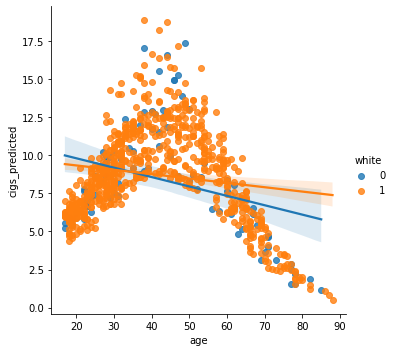

In [29]:
sns.lmplot(data=SmokeDataFramePredictions,x="age", y="cigs_predicted", hue="white",height=5)

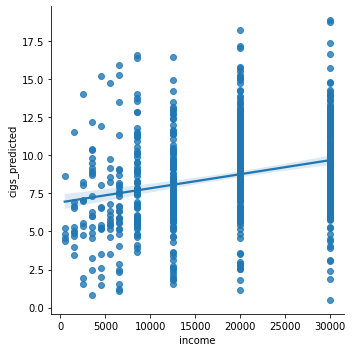

In [39]:
sns.lmplot(data=SmokeDataFramePredictions,x="income", y="cigs_predicted",height=5)

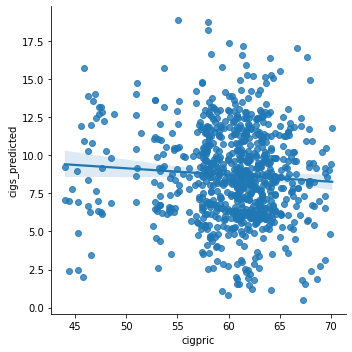

In [38]:
sns.lmplot(data=SmokeDataFramePredictions,x="cigpric", y="cigs_predicted",height=5)

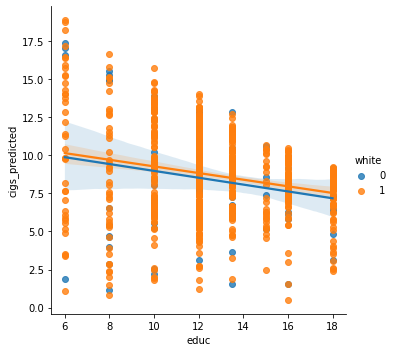

In [40]:
sns.lmplot(data=SmokeDataFramePredictions,x="educ", y="cigs_predicted", hue="white",height=5)